In [1]:
import pandas as pd
import glob
import seaborn as sns
sns.set(rc={'figure.figsize':(4,3)})

In [2]:
# PBMC Neo HG38
neo_='https://ftp.ncbi.nlm.nih.gov/geo/series/GSE140nnn/GSE140730/matrix/GSE140730-GPL20795_series_matrix.txt.gz'
neo=pd.read_csv(neo_,sep='\t',skiprows=31).T
neo=neo[neo[10]=='diagnosis: TD']
GSE140730=neo[44].to_dict()

In [ ]:
%%time
for gse,link in GSE140730.items():
    !wget -q -nc "{link}" -O "data/meth/neo/{gse}.txt.gz"   

In [ ]:
%%time
gsms=neo[43].index 
for i in range(50):
    gsm=gsms[i]
    print(gsm,end=',')
    neo=pd.read_table('data/meth/neo/'+gsm+'.txt.gz',header=None,usecols=[0,1,3,4])
    neo=neo[neo[0].isin(['chr'+str(c) for c in range(1,23)])].copy()
    neo.index=neo[0].str[3:].astype(int)*10**9+neo[1]
    gsm=gsm.strip('Discovery_TD')
    neo[gsm+'_cov']=neo[3]+neo[4]
    neo[gsm+'_beta']=neo[3]/neo[gsm+'_cov']
    neo.sort_index(inplace=True)
    neo[[gsm+'_cov',gsm+'_beta']].to_csv('data/meth/neo/csv/'+gsm+'.csv')

In [4]:
for name in ['M_'+format(c, '02d') for c in range(1,36)]+['F_'+format(c, '02d') for c in range(1,16)]:
    df=pd.read_csv('data/meth/neo/csv/'+name+'.csv',index_col=0)
    df['m']=(df.iloc[:,0]*df.iloc[:,1]).fillna(0).astype(int)
    df1=df.iloc[::2]
    df2=df.iloc[1::2]
    df2.index=df2.index-1
    dg=pd.DataFrame(df1.iloc[:,0]+df2.iloc[:,0])
    dg[name+'_beta']=((df1['m']+df2['m'])/dg.iloc[:,0]).round(3)
    print(dg.mean().values,end=',')
    dg.to_csv('data/meth/neo/csv/sym/'+name+'.csv')

[3.18592861 0.7827478 ],[6.41729548 0.80859289],[5.87386885 0.79919755],[5.88349921 0.80723392],[6.14076084 0.79502478],[5.24074394 0.76207878],[5.81906961 0.81124945],[5.22023084 0.80921161],[5.11013348 0.80591659],[4.90698814 0.79862552],[3.67110323 0.79381301],[2.39801762 0.79293369],[3.93878534 0.79617267],[4.2472033  0.79247373],[3.42030638 0.78466645],[1.68770192 0.78654665],

In [3]:
%%time
dfs=[]
for name in ['M_'+format(c, '02d') for c in range(1,36)]+['F_'+format(c, '02d') for c in range(1,16)]:
    print(name,end=',')
    df=pd.read_csv('data/meth/neo/csv/sym/'+name+'.csv',index_col=0)
    df['m']=(df.iloc[:,0]*df.iloc[:,1]).fillna(0).astype(int)
    dfs.append(df)    

M_01,M_02,M_03,M_04,M_05,M_06,M_07,M_08,M_09,M_10,M_11,M_12,M_13,M_14,M_15,M_16,M_17,M_18,M_19,M_20,M_21,M_22,M_23,M_24,M_25,M_26,M_27,M_28,M_29,M_30,M_31,M_32,M_33,M_34,M_35,F_01,F_02,F_03,F_04,F_05,F_06,F_07,F_08,F_09,F_10,F_11,F_12,F_13,F_14,F_15,

In [4]:
%%time
dg=pd.concat([df.iloc[:,1] for df in dfs],axis=1)
print(len(dg))

27852739


In [9]:
%%time 
dg.to_csv('data/meth/neo/csv/sym/all.csv')

CPU times: user 14min 2s, sys: 15.4 s, total: 14min 17s
Wall time: 14min 18s


In [13]:
dg.corrwith(dg.iloc[:,0]).sort_values().values

27852739


array([0.71876303, 0.74417575, 0.74775356, 0.74995832, 0.75773999,
       0.75896797, 0.75969385, 0.76433916, 0.76532934, 0.76638841,
       0.76705705, 0.77318523, 0.77373859, 0.77677269, 0.78142974,
       0.7851703 , 0.78535237, 0.78749737, 0.78852892, 0.78860372,
       0.78874948, 0.79103973, 0.79171312, 0.79183622, 0.79333118,
       0.79396856, 0.79501006, 0.79633519, 0.79717191, 0.79731649,
       0.79753187, 0.79786968, 0.79803541, 0.79890829, 0.79981935,
       0.80031772, 0.80082648, 0.80093504, 0.8011402 , 0.80166304,
       0.80307292, 0.80451438, 0.8052915 , 0.80539966, 0.80587363,
       0.80636162, 0.8065682 , 0.80786153, 0.80986556, 1.        ])

In [14]:
neo=pd.DataFrame(pd.concat([df['m'] for df in dfs],axis=1).sum(1).rename('m'))
neo['cov']=pd.concat([df.iloc[:,0] for df in dfs],axis=1).sum(1)
neo['beta']=(neo['m']/neo['cov']).round(3)

Text(0.5, 0, 'DNA methylation level')

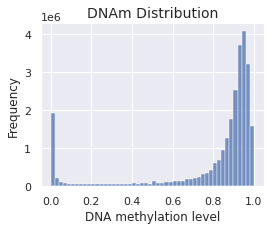

In [20]:
g=sns.histplot(neo['beta'],bins=50)
g.set_title("DNAm Distribution", fontsize = 14)
g.set_ylabel("Frequency", fontsize = 12)
g.set_xlabel("DNA methylation level", fontsize = 12)

In [25]:
neo.index=neo.index.rename('g')

In [26]:
neo.to_csv('data/meth/neo.csv')

In [28]:
neo=pd.read_csv('data/meth/neo.csv',index_col=0)

In [29]:
neo['ch']=(neo.index/10**9).astype(int)
neo['pos']=neo.index-neo['ch']*10**9
neo['ch']='chr'+neo['ch'].astype(str)

In [30]:
neo['plus']='+'
neo['cpg']='CpG'

In [25]:
neo=neo.fillna(0)

In [26]:
neo[['ch','pos','plus','cpg','beta','cov']].to_csv('data/meth/neo/meth_count.csv',index=False,header=False,sep='\t')

In [ ]:
#run hmr in bash to get count to hmr

In [51]:
hmr=pd.read_csv('data/meth/neo/hmr.csv',sep='\t',header=None)

In [52]:
hmr['d']=hmr[2]-hmr[1]

In [53]:
hmr.sort_values('d')

,0,1,2,3,4,5,d
49322,chr17,42057499,42057514,HYPO49322,8,+,15
14821,chr4,138589798,138589815,HYPO14821,9,+,17
19944,chr6,101988134,101988155,HYPO19944,11,+,21
3235,chr1,107574994,107575015,HYPO3235,9,+,21
61520,chr22,47379338,47379363,HYPO61520,7,+,25
...,...,...,...,...,...,...,...
22975,chr7,96987424,97028040,HYPO22975,1190,+,40616
16458,chr5,93567876,93617173,HYPO16458,1482,+,49297
44350,chr15,96318996,96370999,HYPO44350,1871,+,52003
9014,chr2,176066378,176141030,HYPO9014,2965,+,74652
